# Object Detection with YOLO using Darknet

YOLO (“You Only Look Once”) is an effective real-time object recognition algorithm, first described in the seminal [2015 paper by Joseph Redmon et al.](https://arxiv.org/abs/1506.02640)

[Darknet](https://pjreddie.com/darknet/) is an open source neural network framework written in C and CUDA that include an implementation of YOLO in various versions

## Create customed COCO dataset for YOLO Training using Fiftyone
[COCO](https://cocodataset.org/#home)  is a large-scale object detection, segmentation, and captioning dataset, that is regularly used for Computer Vision challenges.
As we want to train a YOLO network that can detect persons, busses and trucks we first create a customed dataset from COCO that contains solely these three classes. 

We therefor use the open-source tool [FiftyOne](https://voxel51.com/docs/fiftyone/) that makes it easier to download, visualize, and evaluate COCO

In [1]:
# install specific versions of folium and opencv-pythin-headless to enable fiftyone running in google colab
!pip install folium==0.2.1
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 69 kB 3.0 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=2148f45620f1eee6bb416867ba128c05a3f61f985ab0b81debb9eb06d8eed159
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 21.8 MB 1.5 MB/s 


In [2]:
!pip install fiftyone

     |████████████████████████████████| 1.2 MB 4.0 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 226 kB 40.3 MB/s 
     |████████████████████████████████| 13.2 MB 43.4 MB/s 
     |████████████████████████████████| 79.9 MB 1.4 MB/s 
     |████████████████████████████████| 640 kB 53.0 MB/s 
     |████████████████████████████████| 106 kB 51.3 MB/s 
     |████████████████████████████████| 29.2 MB 1.5 MB/s 
     |████████████████████████████████| 508 kB 50.0 MB/s 
     |████████████████████████████████| 131 kB 53.3 MB/s 
     |████████████████████████████████| 563 kB 51.5 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 8.5 MB 33.3 MB/s 
     |████████████████████

In [3]:
import fiftyone.zoo as foz

### Training data

In [4]:
dataset_train = foz.load_zoo_dataset(
    'coco-2017',
    split='train',
    label_types=['detections'],
    classes=['person','bus','truck'],
    max_samples=600,
    # shuffle=True
)

 100% |██████|    1.9Gb/1.9Gb [16.2s elapsed, 0s remaining, 127.7Mb/s]      
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |██████████████████| 600/600 [5.2m elapsed, 0s remaining, 1.9 images/s]      
Writing annotations for 600 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████████| 600/600 [9.9s elapsed, 0s remaining, 57.6 samples/s]       
Dataset 'coco-2017-train-600' created


In [5]:
from fiftyone import ViewField as F 

# create dataset that contains only persons, cars and trucks
view_train = dataset_train.filter_labels('ground_truth', F('label').is_in(['person','bus','truck']))

In [6]:
import fiftyone as fo

# store customed COCO dataset in dedicated folder

export_dir = "./YoloData/Training"
label_field = 'ground_truth'

view_train.export(
    export_dir = export_dir,
    dataset_type = fo.types.YOLOv4Dataset,
    label_field = label_field,
    export_media = 'move'
)

 100% |█████████████████| 600/600 [3.9s elapsed, 0s remaining, 152.9 samples/s]      


### Validation Data

In [7]:
dataset_val = foz.load_zoo_dataset(
    'coco-2017',
    split='validation',
    label_types=['detections'],
    classes=['person','bus','truck'],
    max_samples=300,
)

Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████████████████| 300/300 [2.5m elapsed, 0s remaining, 1.8 images/s]      
Writing annotations for 300 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 300/300 [2.9s elapsed, 0s remaining, 115.6 samples/s]      
Dataset 'coco-2017-validation-300' created


In [8]:
# create dataset that contains only persons, cars and trucks
view_val = dataset_val.filter_labels('ground_truth', F('label').is_in(['person','bus','truck']))

In [9]:
export_dir = "./YoloData/Validation"
label_field = 'ground_truth'

view_val.export(
    export_dir = export_dir,
    dataset_type = fo.types.YOLOv4Dataset,
    label_field = label_field,
    export_media = 'move'
)

 100% |█████████████████| 300/300 [1.1s elapsed, 0s remaining, 291.1 samples/s]         


As we want to use only three classes we have to adjust the category labels to [0:2]

In [10]:
# helper function to transform original COCO classes to [0:2]
def adjust_classes(line):
  transform_dict= {'1':'0','6':'1','8':'2'}
  transformed_line = transform_dict[line[0]] + line[1:]
  return transformed_line

In [11]:
def adjust_filecontent(file_list):
  for file in file_list:
    with open(file) as f:
      contents = f.readlines()

    with open(file, 'w') as f:
      for line in contents:
        f.write(adjust_classes(line))   

In [12]:
import glob

adjust_filecontent(glob.glob('./YoloData/Training/data/*.txt')) 
adjust_filecontent(glob.glob('./YoloData/Validation/data/*.txt')) 

## Create YOLO model with Darknet

### Setup Darknet

In [13]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 13.99 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (10354/10354), done.


In [14]:
%cd darknet

/content/darknet


In [18]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv

### Run inference on pretrained YOLO model
Just for demo purposes 😀

In [19]:
# load pre-trained model weights
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [20]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

In [21]:
!pip install -q torch_snippets

     |████████████████████████████████| 41 kB 272 kB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 10.9 MB 20.1 MB/s 
     |████████████████████████████████| 215 kB 52.6 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 


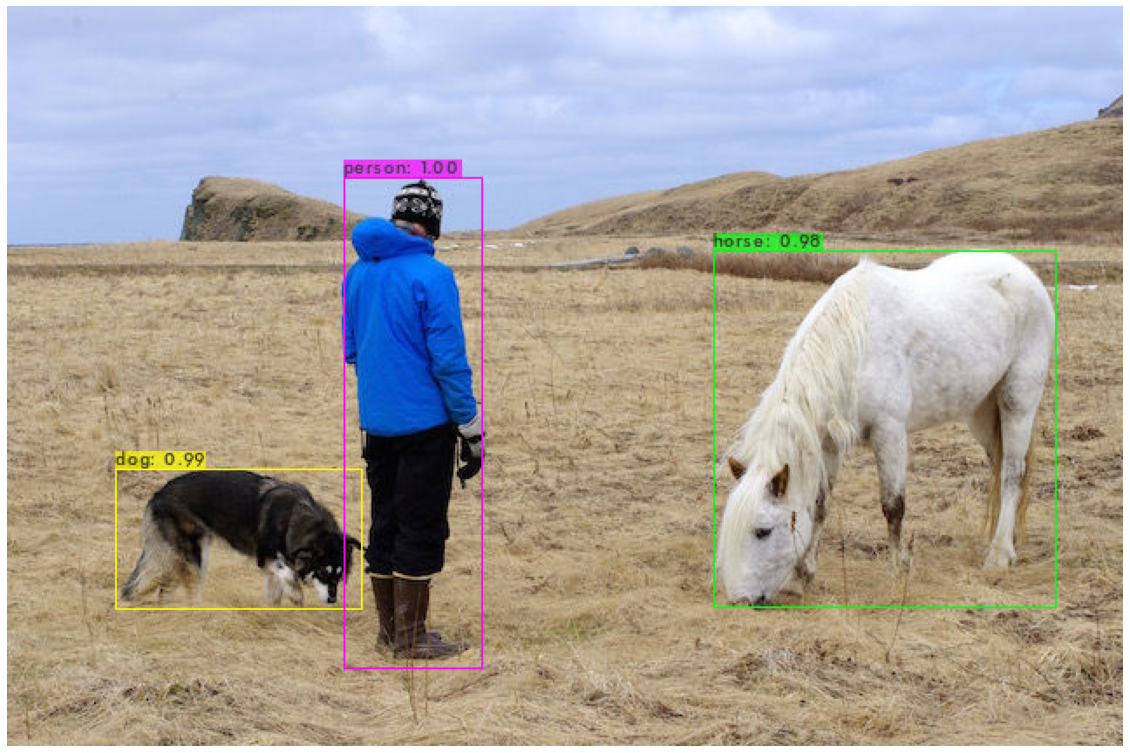

In [22]:
from torch_snippets import Glob, stem, show, read
show('predictions.jpg')

## Train customed YOLO model

In [23]:
%%writefile data/obj.names
person
bus
truck

Writing data/obj.names


In [24]:
%%writefile data/obj.data
classes = 3
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [25]:
!mkdir -p data/obj
!cp -r /content/YoloData/Training/data/*.jpg data/
!cp -r /content/YoloData/Validation/data/*.jpg data/
!cp -r /content/YoloData/Training/images.txt data/train.txt
!cp -r /content/YoloData/Validation/images.txt data/val.txt
!cp -r /content/YoloData/Training/data/*.txt data/
!cp -r /content/YoloData/Validation/data/*.txt data/

1.   Equation to set max batches (classes*2000)
2.   Filters: (classes + 5)x3 in the 3 convolutional layer.






In [26]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-person-bus-trucks.cfg

# max_batches to 6000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=6000/' cfg/yolov4-tiny-person-bus-trucks.cfg   

# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-person-bus-trucks.cfg  

# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=320,360/' cfg/yolov4-tiny-person-bus-trucks.cfg  

# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=3/g' cfg/yolov4-tiny-person-bus-trucks.cfg

# in the classification and regression heads, change number of output convolution filters
# from 255 -> 24 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=24/g' cfg/yolov4-tiny-person-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-person-bus-trucks.cfg

In [27]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [28]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.607176), count: 23, class_loss = 3.338942, iou_loss = 47.269501, total_loss = 50.608444 
 total_bbox = 3223160, rewritten_bbox = 7.929175 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.585734), count: 4, class_loss = 0.968455, iou_loss = 0.442097, total_loss = 1.410552 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.429985), count: 46, class_loss = 8.624348, iou_loss = 100.880920, total_loss = 109.505272 
 total_bbox = 3223210, rewritten_bbox = 7.929238 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.619752), count: 6, class_loss = 0.932883, iou_loss = 0.351246, total_loss = 1.284129 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.590275), count: 21, class_loss = 3.648719, iou_loss = 33.045395, to

### Save Model

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!cp data/obj.data /content/drive/MyDrive/Yolo/
!cp cfg/yolov4-tiny-person-bus-trucks.cfg /content/drive/MyDrive/Yolo/
!cp backup//yolov4-tiny-person-bus-trucks_final.weights /content/drive/MyDrive/Yolo/

In [32]:
!./darknet detector test data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg backup//yolov4-tiny-person-bus-trucks_final.weights '/content/drive/MyDrive/Images/Truck_Person_Image.jpg'

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

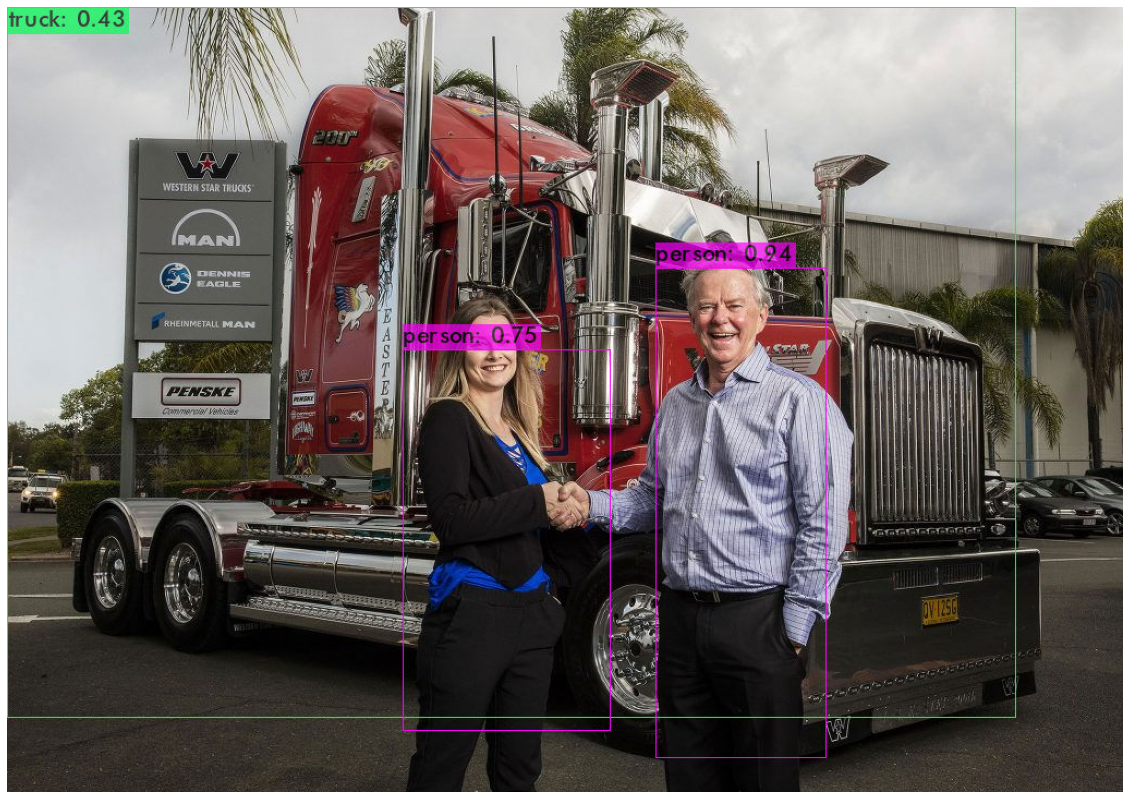

In [33]:
show('predictions.jpg')

### Inference on Video File

In [34]:
!./darknet detector demo data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg backup//yolov4-tiny-person-bus-trucks_final.weights -dont_show '/content/drive/MyDrive/Images/Volvo Trucks - The Epic Split feat. Van Damme - cut.mp4' -i 0 -out_filename /content/drive/MyDrive/Images/Volvo_detected.mp4

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.

FPS:38.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 95% 

FPS:38.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 89% 

FPS:37.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 89% 

FPS:37.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 87% 

FPS:37.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 91% 

FPS:37.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 87% 

FPS:36.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 85% 

FPS:37.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 84% 

FPS:37.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

person: 87% 

FPS:37.3 	 AVG_FPS:37.6

 cvWriteFrame 
Objects:

person: 89% 

FPS:38.1 	 AVG_FPS:37.6

 cvWriteFrame 
Objects:

person: 89% 

FPS:37.7 	 AVG_FPS:37.6

 cvWriteFrame 
Objects:

person: 83% 

FPS:37.6 	 AVG_FPS:37.6

 cvWriteFrame 
Objects:

person: 82% 

FPS:38.9 	 AVG_FPS:37.6

 cvWriteFrame 
Objects:

person: 83% 

FPS:39.3 	 AVG_FPS:37.6

 cvWriteFrame 
Objec

### Export trained model as ONNX

In [35]:
%cd ..

/content


In [36]:
! git clone https://github.com/Tianxiaomo/pytorch-YOLOv4

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 1046, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1046 (delta 31), reused 41 (delta 15), pack-reused 981
Receiving objects: 100% (1046/1046), 2.40 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (636/636), done.


In [38]:
%cd pytorch-YOLOv4/

/content/pytorch-YOLOv4


In [39]:
from tool.darknet2onnx import transform_to_onnx

In [40]:
CFGFILE = '../darknet/cfg/yolov4-tiny-person-bus-trucks.cfg'
WEIGHTFILE = '../darknet/backup/yolov4-tiny-person-bus-trucks_final.weights'
transform_to_onnx(CFGFILE, WEIGHTFILE, batch_size=1, onnx_file_name='yolov4-tiny-person-bus-trucks.onnx')

layer     filters    size              input                output
    0 conv     32  3 x 3 / 2   416 x 416 x   3   ->   208 x 208 x  32
    1 conv     64  3 x 3 / 2   208 x 208 x  32   ->   104 x 104 x  64
    2 conv     64  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x  64
    3 route  2
    4 conv     32  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x  32
    5 conv     32  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  32
    6 route  5 4
    7 conv     64  1 x 1 / 1   104 x 104 x  64   ->   104 x 104 x  64
    8 route  2 7
    9 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x  64
   10 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128
   11 route  10
   12 conv     64  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x  64
   13 conv     64  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x  64
   14 route  13 12
   15 conv    128  1 x 1 / 1    52 x  52 x 128   ->    52 x  52 x 128
   16 route  10 15
   17 max          2 x 2 / 2    52 x  52 x 256   ->    26 x 

/content/pytorch-YOLOv4/tool/darknet2pytorch.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = outputs[layers[0]][:, b // groups * group_id:b // groups * (group_id + 1)]
/content/pytorch-YOLOv4/tool/yolo_layer.py:227: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  bx = bxy[:, ii : ii + 1] + torch.tensor(grid_x, device=device, dtype=torch.float32) # grid_x.to(device=device, dtype=torch.float32)
/cont

Onnx model exporting done


'yolov4_1_3_416_416_static.onnx'

In [41]:
! cp yolov4_1_3_416_416_static.onnx '/content/drive/MyDrive/Yolo/yolov4-tiny-person-bus-trucks.onnx'